In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Preprocessing

In [ ]:
import glob
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
# Define global constants
WORKING_DIR = '/content/drive/My Drive/HushUp/EmotionDetection/Models'
LABELS = '/content/drive/My Drive/HushUp/EmotionDetection/target_labels.csv'
FEATURE_FILE = '/content/drive/My Drive/HushUp/EmotionDetection/pyaud_iemocap_features.csv'

In [ ]:
# clean labelled data
df_target = pd.read_csv(LABELS, usecols=['wav_filename', 'emotion_category', 'emotion_dimensions'])
df_target['emotion_dimensions'] = df_target['emotion_dimensions'].apply(lambda x: x[1:-2]) 
df_target[['valence', 'arousal', 'dominance']] = df_target.emotion_dimensions.str.split(pat = ',', expand= True)
df_target.drop(columns=['emotion_dimensions'], inplace=True)
df_target['file_name'] = df_target['wav_filename']
df_target.drop(columns=['wav_filename'], inplace=True)
df_target.head()

,emotion_category,valence,arousal,dominance,file_name
0,neu,2.5000,2.5000,2.5000,Ses01F_impro01_F000
1,neu,2.5000,2.5000,2.5000,Ses01F_impro01_F001
2,neu,2.5000,2.5000,2.5000,Ses01F_impro01_F002
3,xxx,2.5000,3.0000,3.0000,Ses01F_impro01_F003
4,xxx,2.5000,3.0000,2.5000,Ses01F_impro01_F004


In [ ]:
columns = ['file_name']
for i in range(1360):
  columns.append('aud_f_'+str(i))

In [ ]:
# for f1 input set
feature_df = pd.read_csv(FEATURE_FILE)

# for f2 input set
# feature_df = pd.read_csv(FEATURE_FILE, names=columns)

feature_df['file_name'] = feature_df.apply(lambda x: x['file_name'].split('.')[0], axis=1)
feature_df.head()

,file_name,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,mfcc_12_mean,mfcc_13_mean,chroma_1_mean,chroma_2_mean,chroma_3_mean,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,delta zcr_mean,delta energy_mean,delta energy_entropy_mean,delta spectral_centroid_mean,delta spectral_spread_mean,...,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,chroma_std_std,delta zcr_std,delta energy_std,delta energy_entropy_std,delta spectral_centroid_std,delta spectral_spread_std,delta spectral_entropy_std,delta spectral_flux_std,delta spectral_rolloff_std,delta mfcc_1_std,delta mfcc_2_std,delta mfcc_3_std,delta mfcc_4_std,delta mfcc_5_std,delta mfcc_6_std,delta mfcc_7_std,delta mfcc_8_std,delta mfcc_9_std,delta mfcc_10_std,delta mfcc_11_std,delta mfcc_12_std,delta mfcc_13_std,delta chroma_1_std,delta chroma_2_std,delta chroma_3_std,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,Ses01F_impro01_F000,0.111706,0.018731,3.076731,0.210259,0.221901,0.840340,0.009257,0.169639,-26.456938,2.005109,0.127792,0.003338,-0.059965,0.042261,0.004267,0.004471,-0.141153,-0.135556,-0.219182,-0.069538,-0.034476,0.015161,0.006939,0.075994,0.027818,0.030014,0.015497,0.083754,0.001740,0.004540,0.008409,0.023395,0.003650,0.039621,0.000431,-0.000164,-0.001597,-0.000190,0.000135,...,0.001879,0.003526,0.006524,0.021110,0.003521,0.013757,0.043583,0.031746,0.305548,0.028194,0.019996,0.342306,0.007535,0.096384,1.027569,0.492314,0.327601,0.259549,0.249637,0.221959,0.249815,0.243053,0.240351,0.252902,0.220503,0.255342,0.201901,0.030587,0.009578,0.084358,0.038514,0.037881,0.020958,0.076307,0.002159,0.003680,0.007185,0.024084,0.004604,0.015072
1,Ses01F_impro01_F001,0.088150,0.005930,3.072951,0.180198,0.203250,0.764643,0.005339,0.120964,-28.971886,2.087442,-0.181832,0.210334,-0.087907,0.193208,0.023974,0.099168,0.049331,-0.218462,-0.095437,-0.010956,-0.022610,0.014455,0.007211,0.101802,0.009338,0.020827,0.007540,0.089632,0.001302,0.004397,0.010277,0.026305,0.006237,0.038303,-0.004465,0.000002,0.002152,-0.002800,-0.000371,...,0.000861,0.001891,0.009472,0.013538,0.010069,0.013276,0.024056,0.012539,0.290295,0.019004,0.019154,0.290976,0.003410,0.035317,1.105605,0.405066,0.237460,0.267578,0.259468,0.230917,0.212163,0.162919,0.130121,0.214040,0.212857,0.208021,0.233099,0.019240,0.007276,0.067378,0.008580,0.014901,0.010667,0.065497,0.001205,0.002832,0.012949,0.019411,0.010764,0.013834
2,Ses01F_impro01_F002,0.089362,0.003974,3.117304,0.166102,0.189936,0.684451,0.006942,0.126906,-29.166862,2.307542,-0.187309,0.156821,-0.011710,0.089391,0.096484,0.068352,-0.152501,-0.165110,-0.080778,-0.023180,0.051081,0.007911,0.006348,0.071289,0.013232,0.031388,0.009010,0.108979,0.002818,0.005158,0.010204,0.032030,0.004120,0.038713,-0.000407,-0.000002,0.008805,0.000203,-0.000138,...,0.005078,0.004337,0.008495,0.019896,0.006164,0.010768,0.031647,0.005156,0.168214,0.030376,0.018061,0.274692,0.003277,0.080558,0.688139,0.357784,0.279383,0.190123,0.273772,0.199996,0.213203,0.202993,0.202793,0.151323,0.184487,0.209371,0.201869,0.009248,0.006566,0.047022,0.015515,0.024090,0.008399,0.058130,0.006120,0.007213,0.010841,0.025057,0.008813,0.012496
3,Ses01F_impro01_F003,0.097719,0.016175,3.145265,0.192284,0.208525,0.835261,0.007382,0.140597,-27.571512,2.109362,0.191085,-0.043391,-0.048384,0.235859,0.019778,0.060001,-0.068814,-0.287394,-0.076850,-0.077765,0.001094,0.012359,0.005507,0.076431,0.022531,0.023913,0.009572,0.066119,0.001463,0.004892,0.008263,0.036571,0.003378,0.032968,-0.000803,-0.000016,-0.000047,0.000862,0.001334

In [ ]:
master_df = pd.merge(df_target, feature_df, on='file_name')
master_df.head()

,emotion_category,valence,arousal,dominance,file_name,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,mfcc_12_mean,mfcc_13_mean,chroma_1_mean,chroma_2_mean,chroma_3_mean,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,delta zcr_mean,...,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,chroma_std_std,delta zcr_std,delta energy_std,delta energy_entropy_std,delta spectral_centroid_std,delta spectral_spread_std,delta spectral_entropy_std,delta spectral_flux_std,delta spectral_rolloff_std,delta mfcc_1_std,delta mfcc_2_std,delta mfcc_3_std,delta mfcc_4_std,delta mfcc_5_std,delta mfcc_6_std,delta mfcc_7_std,delta mfcc_8_std,delta mfcc_9_std,delta mfcc_10_std,delta mfcc_11_std,delta mfcc_12_std,delta mfcc_13_std,delta chroma_1_std,delta chroma_2_std,delta chroma_3_std,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,neu,2.5000,2.5000,2.5000,Ses01F_impro01_F000,0.111706,0.018731,3.076731,0.210259,0.221901,0.840340,0.009257,0.169639,-26.456938,2.005109,0.127792,0.003338,-0.059965,0.042261,0.004267,0.004471,-0.141153,-0.135556,-0.219182,-0.069538,-0.034476,0.015161,0.006939,0.075994,0.027818,0.030014,0.015497,0.083754,0.001740,0.004540,0.008409,0.023395,0.003650,0.039621,0.000431,...,0.001879,0.003526,0.006524,0.021110,0.003521,0.013757,0.043583,0.031746,0.305548,0.028194,0.019996,0.342306,0.007535,0.096384,1.027569,0.492314,0.327601,0.259549,0.249637,0.221959,0.249815,0.243053,0.240351,0.252902,0.220503,0.255342,0.201901,0.030587,0.009578,0.084358,0.038514,0.037881,0.020958,0.076307,0.002159,0.003680,0.007185,0.024084,0.004604,0.015072
1,neu,2.5000,2.5000,2.5000,Ses01F_impro01_F001,0.088150,0.005930,3.072951,0.180198,0.203250,0.764643,0.005339,0.120964,-28.971886,2.087442,-0.181832,0.210334,-0.087907,0.193208,0.023974,0.099168,0.049331,-0.218462,-0.095437,-0.010956,-0.022610,0.014455,0.007211,0.101802,0.009338,0.020827,0.007540,0.089632,0.001302,0.004397,0.010277,0.026305,0.006237,0.038303,-0.004465,...,0.000861,0.001891,0.009472,0.013538,0.010069,0.013276,0.024056,0.012539,0.290295,0.019004,0.019154,0.290976,0.003410,0.035317,1.105605,0.405066,0.237460,0.267578,0.259468,0.230917,0.212163,0.162919,0.130121,0.214040,0.212857,0.208021,0.233099,0.019240,0.007276,0.067378,0.008580,0.014901,0.010667,0.065497,0.001205,0.002832,0.012949,0.019411,0.010764,0.013834
2,neu,2.5000,2.5000,2.5000,Ses01F_impro01_F002,0.089362,0.003974,3.117304,0.166102,0.189936,0.684451,0.006942,0.126906,-29.166862,2.307542,-0.187309,0.156821,-0.011710,0.089391,0.096484,0.068352,-0.152501,-0.165110,-0.080778,-0.023180,0.051081,0.007911,0.006348,0.071289,0.013232,0.031388,0.009010,0.108979,0.002818,0.005158,0.010204,0.032030,0.004120,0.038713,-0.000407,...,0.005078,0.004337,0.008495,0.019896,0.006164,0.010768,0.031647,0.005156,0.168214,0.030376,0.018061,0.274692,0.003277,0.080558,0.688139,0.357784,0.279383,0.190123,0.273772,0.199996,0.213203,0.202993,0.202793,0.151323,0.184487,0.209371,0.201869,0.009248,0.006566,0.047022,0.015515,0.024090,0.008399,0.058130,0.006120,0.007213,0.010841,0.025057,0.008813,0.012496
3,xxx,2.5000,3.0000,3.0000,Ses01F_impro01_F003,0.097719,0.016175,3.145265,0.192284,0.208525,0.835261,0.007382,0.140597,-27.571512,2.109362,0.191085,-0.043391,-0.048384,0.235859,0.019778,0.060001,-0.068814,-0.287394,-0.076850,-0.077765,0.001094,0.012359,0.005507,0.076431,0.022531,0.023913,0.009572,0.066119,0.001463,0.004892,0.008263,0.036571,0.003378,0.032968,-0.000803,...,0.001419,0.004293,0.006929,0.031597,0.003143,0.011690,0.035952,0.022763,0.087575,0.026582,0.018460,0.3485

# Train Test split

In [ ]:
# Scale output between 0 and 1
master_df['arousal'] = master_df.apply(lambda x: float(x['arousal'])/5,axis=1)
master_df['valence'] = master_df.apply(lambda x: float(x['valence'])/5,axis=1)
master_df['dominance'] = master_df.apply(lambda x: float(x['dominance'])/5,axis=1)

In [ ]:
# for f1 input set
feature_list = ['zcr_mean',
       'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean',
       'spectral_spread_mean', 'spectral_entropy_mean',
       'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean',
       'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean',
       'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean',
       'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean',
       'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean',
       'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean',
       'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean',
       'chroma_12_mean', 'chroma_std_mean', 'delta zcr_mean',
       'delta energy_mean', 'delta energy_entropy_mean',
       'delta spectral_centroid_mean', 'delta spectral_spread_mean',
       'delta spectral_entropy_mean', 'delta spectral_flux_mean',
       'delta spectral_rolloff_mean', 'delta mfcc_1_mean',
       'delta mfcc_2_mean', 'delta mfcc_3_mean', 'delta mfcc_4_mean',
       'delta mfcc_5_mean', 'delta mfcc_6_mean', 'delta mfcc_7_mean',
       'delta mfcc_8_mean', 'delta mfcc_9_mean', 'delta mfcc_10_mean',
       'delta mfcc_11_mean', 'delta mfcc_12_mean', 'delta mfcc_13_mean',
       'delta chroma_1_mean', 'delta chroma_2_mean',
       'delta chroma_3_mean', 'delta chroma_4_mean',
       'delta chroma_5_mean', 'delta chroma_6_mean',
       'delta chroma_7_mean', 'delta chroma_8_mean',
       'delta chroma_9_mean', 'delta chroma_10_mean',
       'delta chroma_11_mean', 'delta chroma_12_mean',
       'delta chroma_std_mean', 'zcr_std', 'energy_std',
       'energy_entropy_std', 'spectral_centroid_std',
       'spectral_spread_std', 'spectral_entropy_std', 'spectral_flux_std',
       'spectral_rolloff_std', 'mfcc_1_std', 'mfcc_2_std', 'mfcc_3_std',
       'mfcc_4_std', 'mfcc_5_std', 'mfcc_6_std', 'mfcc_7_std',
       'mfcc_8_std', 'mfcc_9_std', 'mfcc_10_std', 'mfcc_11_std',
       'mfcc_12_std', 'mfcc_13_std', 'chroma_1_std', 'chroma_2_std',
       'chroma_3_std', 'chroma_4_std', 'chroma_5_std', 'chroma_6_std',
       'chroma_7_std', 'chroma_8_std', 'chroma_9_std', 'chroma_10_std',
       'chroma_11_std', 'chroma_12_std', 'chroma_std_std',
       'delta zcr_std', 'delta energy_std', 'delta energy_entropy_std',
       'delta spectral_centroid_std', 'delta spectral_spread_std',
       'delta spectral_entropy_std', 'delta spectral_flux_std',
       'delta spectral_rolloff_std', 'delta mfcc_1_std',
       'delta mfcc_2_std', 'delta mfcc_3_std', 'delta mfcc_4_std',
       'delta mfcc_5_std', 'delta mfcc_6_std', 'delta mfcc_7_std',
       'delta mfcc_8_std', 'delta mfcc_9_std', 'delta mfcc_10_std',
       'delta mfcc_11_std', 'delta mfcc_12_std', 'delta mfcc_13_std',
       'delta chroma_1_std', 'delta chroma_2_std', 'delta chroma_3_std',
       'delta chroma_4_std', 'delta chroma_5_std', 'delta chroma_6_std',
       'delta chroma_7_std', 'delta chroma_8_std', 'delta chroma_9_std',
       'delta chroma_10_std', 'delta chroma_11_std',
       'delta chroma_12_std', 'delta chroma_std_std']

# for f2 input set
# feature_list = columns[1:]

In [ ]:
# scaling input between -1 and 1
for feature in feature_list:
  master_df[feature] /= (max(abs(np.min(master_df[feature])), np.max(master_df[feature])))

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(master_df[feature_list], master_df[['valence', 'arousal', 'dominance']], test_size=0.2, shuffle=True, random_state=4)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=4)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(8031, 136)
(1004, 136)
(1004, 136)
(8031, 3)
(1004, 3)
(1004, 3)


# Model Training

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import History 
import keras_tuner as kt

from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from glob import glob
import keras
import tensorflow as tf

In [ ]:
def get_model():
    print('Using Model M5')
    inputs = tf.keras.Input(shape=(len(feature_list),))

    dense_1 = Dense(680, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.0000001))(inputs)
    do_1 = Dropout(0.2)(dense_1)
    dense_2 = Dense(340, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.0000001))(do_1)
    do_2 = Dropout(0.2)(dense_2)
    
    dense_3 = Dense(170, activation='relu')(do_2)
    val_output = Dense(1, activation='linear', name='valence_output')(dense_3)

    dense_4 = Dense(170, activation='relu')(do_2)
    aro_output = Dense(1, activation='linear', name='arousal_output')(dense_4)

    dense_5 = Dense(170, activation='relu')(do_2)
    dom_output = Dense(1, activation='linear', name='dominance_output')(dense_5)


    model = tf.keras.Model(inputs, [val_output, aro_output, dom_output])
    return model

In [ ]:
model = get_model()

if model is None:
  exit('Something went wrong!!')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.99)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = opt,loss = 'mean_squared_error', loss_weights=[0.3,0.1,0.2], metrics=[tf.keras.metrics.RootMeanSquaredError()])
print(model.summary())

In [ ]:
#if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
history = History()

batch_size = 32
hist = model.fit(x=X_train,
              y={'valence_output': y_train['valence'],
                'arousal_output': y_train['arousal'],
                'dominance_output': y_train['dominance']},
              batch_size=batch_size,
              epochs=50,
              verbose=1,
              shuffle=True,
              validation_data=(X_val, {'valence_output': y_val['valence'],
                                      'arousal_output': y_val['arousal'],
                                      'dominance_output': y_val['dominance']})
              ,callbacks=[history,es])

# Hyperband Tunning

In [ ]:
def build_tuner_models(hp):
    hp_n_shared_dense_layers = hp.Int("n_shared_dense_layers", min_value=2, max_value=4, step=1)
    hp_n_custom_dense_layers = hp.Int("n_custom_dense_layers", min_value=1, max_value=3, step=1)

    inputs = tf.keras.Input(shape=(len(feature_list),))
    dense = inputs
    for i in range(hp_n_shared_dense_layers):
      hp_n_shared_dense_units = hp.Int("n_shared_dense_units", min_value=256, max_value=1024, step=256)
      dense = Dense(hp_n_shared_dense_units, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.000000001))(dense)

    dense_1 = dense
    dense_2 = dense
    dense_3 = dense
    for i in range(hp_n_custom_dense_layers):
      hp_n_custom_dense_units = hp.Int("n_custom_dense_units", min_value=128, max_value=512, step=64)
      dense_1 = Dense(hp_n_custom_dense_units, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.000000001))(dense_1)
      dense_2 = Dense(hp_n_custom_dense_units, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.000000001))(dense_2)
      dense_3 = Dense(hp_n_custom_dense_units, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.000000001))(dense_3)
    
    val_output = Dense(1, activation='linear', name='valence_output')(dense_1)
    aro_output = Dense(1, activation='linear', name='arousal_output')(dense_2)
    dom_output = Dense(1, activation='linear', name='dominance_output')(dense_3)

    model = tf.keras.Model(inputs, [val_output, aro_output, dom_output])

    alpha = hp.Float("alpha", min_value=0.1, max_value=0.5, step=0.1)
    beta = hp.Float("beta", min_value=0.1, max_value=0.5, step=0.1)
    gamma = hp.Float("gamma", min_value=0.1, max_value=0.5, step=0.1)
    model.compile(optimizer = opt,loss = 'mean_squared_error', 
                  loss_weights=[alpha,beta,gamma],
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
batch_size = 32
tuner = kt.Hyperband(
    build_tuner_models,
    objective=kt.Objective("val_loss", direction="min"),
    max_epochs=20,
    project_name='emotion_model_tunning_3'
)

tuner.search(x=X_train,
              y={'valence_output': y_train['valence'],
                'arousal_output': y_train['arousal'],
                'dominance_output': y_train['dominance']},
              batch_size=batch_size,
              epochs=20,
              verbose=1,
              shuffle=True,
              validation_data=(X_val, {'valence_output': y_val['valence'],
                                      'arousal_output': y_val['arousal'],
                                      'dominance_output': y_val['dominance']}),
             callbacks=[history,es])

Trial 30 Complete [00h 00m 47s]
val_loss: 0.012998941354453564

Best val_loss So Far: 0.007527709007263184
Total elapsed time: 00h 12m 58s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_params = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_params)
model.summary()

In [ ]:
print(best_params.get('alpha'))
print(best_params.get('beta'))
print(best_params.get('gamma'))

In [ ]:
#if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
history = History()

hist = model.fit(x=X_train,
                      y={'valence_output': y_train['valence'],
                        'arousal_output': y_train['arousal'],
                        'dominance_output': y_train['dominance']},
                      batch_size=batch_size,
                      epochs=100,
                      verbose=1,
                      shuffle=True,
                      validation_data=(X_val, {'valence_output': y_val['valence'],
                                              'arousal_output': y_val['arousal'],
                                              'dominance_output': y_val['dominance']}),
                    callbacks=[history,es])

In [ ]:
model.save(WORKING_DIR+'/emotion_model_a_25')

# Model Evaluation

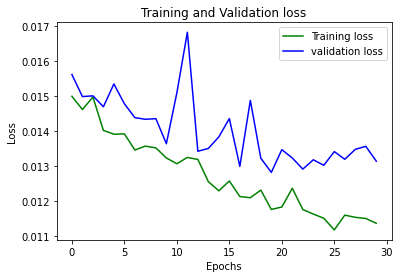

In [ ]:
loss_train = hist.history['loss'][1:]
loss_val = hist.history['val_loss'][1:]

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, {'valence_output': y_test['valence'],
                      'arousal_output': y_test['arousal'],
                      'dominance_output': y_test['dominance']}) 

32/32 [==============================] - 0s 6ms/step - loss: 0.0132 - valence_output_loss: 0.0284 - arousal_output_loss: 0.0109 - dominance_output_loss: 0.0180 - valence_output_root_mean_squared_error: 0.1686 - arousal_output_root_mean_squared_error: 0.1046 - dominance_output_root_mean_squared_error: 0.1342


[0.013227528892457485,
 0.028426002711057663,
 0.010942135006189346,
 0.018017111346125603,
 0.16860012710094452,
 0.10460466146469116,
 0.13422782719135284]

In [ ]:
pred_train = model.predict(X_test)
true_train = y_test['valence'] #np.asarray(y_test['valence'])
plt.plot(true_train, 'go', label='True Labels')
plt.plot(pred_train[0], 'ro', label='Predicted Labels')
plt.title('Predictions')
plt.xlabel('Valence')
plt.legend()
plt.show()

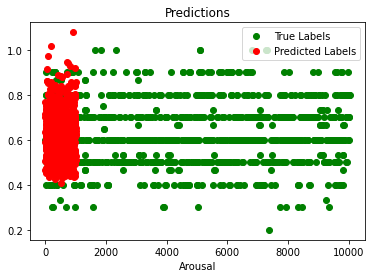

In [ ]:
pred_train = model.predict(X_test)
true_train = y_test['arousal']
plt.plot(true_train, 'go', label='True Labels')
plt.plot(pred_train[1], 'ro', label='Predicted Labels')
plt.title('Predictions')
plt.xlabel('Arousal')
plt.legend()
plt.show()

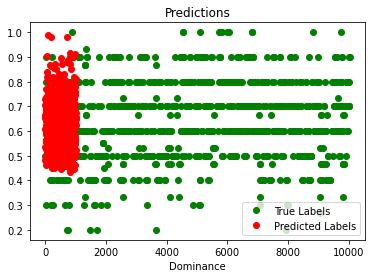

In [ ]:
pred_train = model.predict(X_test)
true_train = y_test['dominance'] #np.asarray(y_test['dominance'])
plt.plot(true_train, 'go', label='True Labels')
plt.plot(pred_train[2], 'ro', label='Predicted Labels')
plt.title('Predictions')
plt.xlabel('Dominance')
plt.legend()
plt.show()